[View in Colaboratory](https://colab.research.google.com/github/mogamin/kaggle-practice-house-prices-advanced-regression-techniques/blob/master/house_prices_advanced_regression_techniques.ipynb)

In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [0]:
!pip install kaggle
!apt-get install -y -qq libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80==4.3.0 
!pip install chainer==4.3.0
!pip install chainercv
!pip install pandas-profiling

In [3]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 7.76MB/s]
  0% 0.00/89.2k [00:00<?, ?B/s]
100% 89.2k/89.2k [00:00<00:00, 49.4MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 62.5MB/s]
  0% 0.00/82.0k [00:00<?, ?B/s]
100% 82.0k/82.0k [00:00<00:00, 50.6MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 74.8MB/s]
  0% 0.00/15.3k [00:00<?, ?B/s]
100% 15.3k/15.3k [00:00<00:00, 16.2MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 32.2MB/s]


In [18]:
import numpy as np
import pandas as pd
import chainer
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

import datetime
now = (datetime.datetime.now() + datetime.timedelta(hours=+9)).strftime('%Y%m%d-%H%M%S')

# fixed random seed
import random
import numpy as np

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(RANDOM_SEED)

GPUID=0
xp = chainer.cuda.cupy
chainer.cuda.Device(GPUID).use()

GPU availability: True
cuDNN availablility: True


In [19]:
import pandas as pd
df_train_orig = pd.read_csv('train.csv')
df_train_orig['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

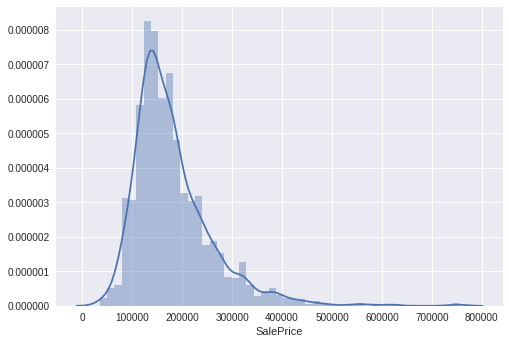

In [20]:
import seaborn as sns
sns.distplot(df_train_orig['SalePrice']);

In [0]:
import matplotlib.pyplot as plt

if 0:
  import pandas_profiling as pdp
  profile = pdp.ProfileReport(df_train_orig)
  profile.to_file(outputfile="df_train_orig.html")

  from IPython.display import HTML
  HTML(filename='df_train_orig.html')

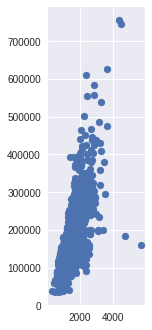

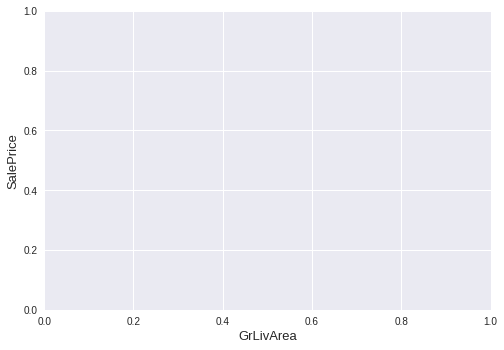

In [22]:
import matplotlib.pyplot as plt
#f = plt.figure(figsize=(12,3))
sub1 = plt.subplot(1,4,1)

fig, ax = plt.subplots()
sub1.scatter(df_train_orig['GrLivArea'], df_train_orig['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [23]:
pickup_columns = [
    'GrLivArea',
    'GarageArea',
    'OverallQual',
    'OverallCond', 
    'YrSold',
    'MoSold'
]

df_train = df_train_orig.loc[:,pickup_columns]
#df_train = pd.get_dummies(df_train, columns=['OverallCond'], drop_first=True)
#df_train = pd.get_dummies(df_train, columns=['OverallQual'], drop_first=True)
#df_train = pd.get_dummies(df_train, columns=['MoSold'], drop_first=True)
#df_train = pd.get_dummies(df_train, columns=['YrSold'], drop_first=True)

if 0:
  df_train = pd.get_dummies(df_train, columns=['BsmtExposure'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['BsmtFinType1'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['BsmtQual'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['ExterQual'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['Exterior1st'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['Exterior2nd'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['Foundation'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['GarageFinish'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['GarageYrBlt'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['HeatingQC'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['YearRemodAdd'], drop_first=True)

df_train['TotalSF'] = df_train_orig['TotalBsmtSF'] + df_train_orig['1stFlrSF'] + df_train_orig['2ndFlrSF']
df_train = df_train.fillna(0)
df_train.head()

,GrLivArea,GarageArea,OverallQual,OverallCond,YrSold,MoSold,TotalSF
0,1710,548,7,5,2008,2,2566
1,1262,460,6,8,2007,5,2524
2,1786,608,7,5,2008,9,2706
3,1717,642,7,5,2006,2,2473
4,2198,836,8,5,2008,12,3343


In [0]:
#sns.heatmap(df_train,df_train)
#df_train.matshow()
#plt.matshow(df_train.corr(),interpolation = 'nearest')

In [25]:
from sklearn.preprocessing import MinMaxScaler, Imputer

def normalization(dataset):
  scaler = MinMaxScaler(feature_range = (0, 1))
  scaler.fit(dataset)
  _transformed_dataset = scaler.transform(dataset)
  _df_transformed_dataset = pd.DataFrame(data=_transformed_dataset, dtype='float')
  return _df_transformed_dataset


df_train_norm = normalization(df_train)
#df_train_norm = df_train
df_train_norm.head()

,0,1,2,3,4,5,6
0,0.259231,0.386460,0.666667,0.500,0.50,0.090909,0.195481
1,0.174830,0.324401,0.555556,0.875,0.25,0.363636,0.191802
2,0.273549,0.428773,0.666667,0.500,0.50,0.727273,0.207742
3,0.260550,0.452750,0.666667,0.500,0.00,0.090909,0.187336
4,0.351168,0.589563,0.777778,0.500,0.50,1.000000,0.263531


In [26]:
x = df_train_norm.values.astype('f')
t = df_train_orig.iloc[:,-1].values.astype('f')
t = t.reshape(len(t), 1)  # t.shape=(1460,) -> (1460, 1) 
dataset = list(zip(x, t))

n_train = int(len(dataset)*0.7)
train, valid = chainer.datasets.split_dataset_random(dataset, n_train, seed=0)
print('len(train)={0}, len(valid)={1}'.format(len(train),len(valid)))

len(train)=1021, len(valid)=439


In [0]:
import chainer
import chainer.links as L
import chainer.functions as F

class NN(chainer.Chain):

    def __init__(self, n_mid_units=64, n_out=1):
        super().__init__()
        initialW = chainer.initializers.HeNormal()
        
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units, initialW=initialW)
            self.fc2 = L.Linear(None, n_mid_units, initialW=initialW)
            self.fc3 = L.Linear(None, n_mid_units, initialW=initialW)
            self.fc4 = L.Linear(None, n_out, initialW=initialW)

    def forward(self, x, t):
        h = self.predictor(x)
        loss = F.mean_squared_error(h, t)
        chainer.report({'loss': loss}, self)
        return loss

    def predictor(self, x):
        h = self.fc1(x)
        h = self.fc2(h)
        h = self.fc3(h)
        h = self.fc4(h)
        return h

In [28]:
import chainer
from chainer import training
from chainer.training import extensions

model = NN()
#chainer.serializers.load_npz("./result/housing/20180926-143319_model_iter_542407", model)
model.to_gpu(GPUID)   

#optimizer = chainer.optimizers.MomentumSGD(lr=0.0000001, momentum=0.9)
optimizer = chainer.optimizers.Adam()
#optimizer = chainer.optimizers.AdaDelta(rho=0.9)
optimizer.setup(model)


batchsize = 16
train_iter = chainer.iterators.SerialIterator(train, batchsize)
valid_iter  = chainer.iterators.SerialIterator(valid,  batchsize, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optimizer, device=GPUID)

epoch = 10000000
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/housing')

#log_interval =  200, 'epoch'
log_interval =  20, 'epoch'
snapshot_interval = 1000 , 'epoch'

trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.Evaluator(valid_iter, model, device=GPUID))
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'elapsed_time','lr','main/loss', 'validation/main/loss']), trigger=log_interval)

trainer.extend(extensions.snapshot(filename=now + '_snapshot_iter_{.updater.iteration}'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(model, now + '_model_iter_{.updater.iteration}'), trigger=snapshot_interval)

#chainer.serializers.load_npz('./20180923-054458_pt26_snapshot_iter_39541', trainer)
trainer.run()

epoch       iteration   elapsed_time  lr          main/loss   validation/main/loss
20          1277        9.36245       0.000849297  1.04975e+10  8.49048e+09           
40          2553        18.6711       0.000960339  2.54039e+09  2.0103e+09            
60          3829        28.0054       0.000989096  1.86959e+09  1.35987e+09           
80          5105        37.34         0.00099697  1.77582e+09  1.27851e+09           
100         6382        46.6258       0.000999156  1.74384e+09  1.25679e+09           
120         7658        55.9548       0.000999765  1.72462e+09  1.24479e+09           
140         8934        65.2545       0.000999934  1.71223e+09  1.24074e+09           
160         10210       74.5288       0.000999982  1.70364e+09  1.24169e+09           
180         11487       83.8546       0.000999995  1.70085e+09  1.23291e+09           
200         12763       93.1801       0.000999999  1.69962e+09  1.23659e+09           
220         14039       102.454       0.001     

KeyboardInterrupt: ignored

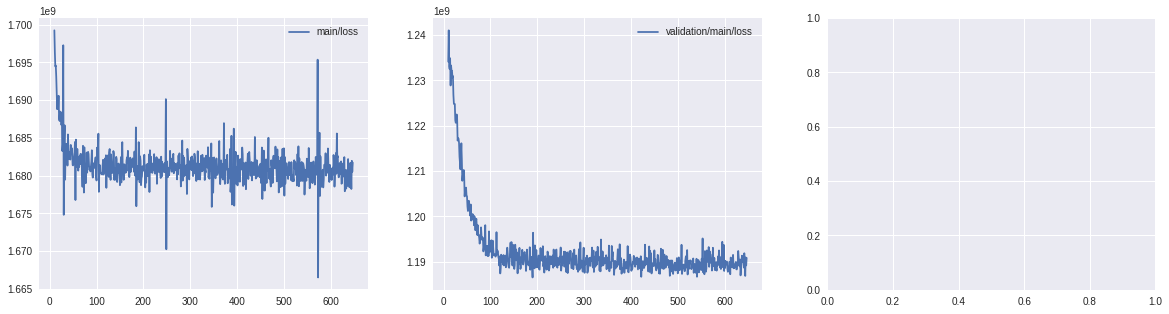

In [29]:
import json
with open('result/housing/log') as f:
  result = pd.DataFrame(json.load(f))

result = result.iloc[10:,:]
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
result[['main/loss']].plot(ax=axes[0])
result[['validation/main/loss']].plot(ax=axes[1])
#result[['lr']].plot(ax=axes[2])

In [33]:
df_test_orig = pd.read_csv('test.csv')
df_test = df_test_orig.loc[:,pickup_columns]
df_test['TotalSF'] = df_test_orig['TotalBsmtSF'] + df_test_orig['1stFlrSF'] + df_test_orig['2ndFlrSF']
df_test = df_test.fillna(0)

df_test_norm = normalization(df_test)
df_test_norm.head()
print(len(df_test_norm))

1459


In [0]:
test_iter = chainer.iterators.SerialIterator(df_test_norm.values.astype('f'), batchsize, repeat=False, shuffle=False)
prediction_list = []

while True:
    test_batch = test_iter.next()
    test_batch = chainer.cuda.to_gpu(test_batch)

    y_hat = model.predictor(test_batch)
    prediction_list += y_hat.data.tolist()

    if test_iter.is_new_epoch:
        test_iter.reset()
        break

submit_a = pd.DataFrame(df_test_orig.loc[:,['Id']].values.tolist())
submit_b = pd.DataFrame(prediction_list)
submit = pd.concat([submit_a, submit_b], axis=1)
submit.columns = ['Id', 'SalePrice']
submit.to_csv("submit.csv", index=False, header=True)

In [35]:
!head submit.csv

Id,SalePrice
1461,148008.21875
1462,186646.90625
1463,170286.796875
1464,196804.890625
1465,245663.421875
1466,191308.859375
1467,182683.203125
1468,180189.171875
1469,222269.640625


In [36]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f  submit.csv -m "submit from colab"

Successfully submitted to House Prices: Advanced Regression Techniques